# Baseline Model

This script applies a linear regression model the data driven feature set, given a baseline preformance for comparison.

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
# set variables from config file
config_path = os.path.abspath('..')

with open(config_path + '/config-example.json', 'r') as f:
    config = json.load(f)

processing_path = config['DEFAULT']['processing_path']
epc_train_clean_fname = config['DEFAULT']['epc_train_clean_fname']
epc_test_clean_fname = config['DEFAULT']['epc_test_clean_fname']
epc_train_dd_fname = config['DEFAULT']['epc_train_dd_fname']
epc_test_dd_fname = config['DEFAULT']['epc_test_dd_fname']
epc_fname_suffix = config['DEFAULT']['epc_fname_suffix']

In [1]:
epc_train = pd.read_csv(os.path.join(processing_path,epc_train_dd_fname) + epc_fname_suffix,header = 0,delimiter = ',')
epc_test = pd.read_csv(os.path.join(processing_path,epc_test_dd_fname) + epc_fname_suffix,header = 0,delimiter = ',')

NameError: name 'pd' is not defined

In [ ]:
epc_train.drop(['BUILDING_REFERENCE_NUMBER','COUNTY','inspection_year'],axis=1,inplace=True)
epc_test.drop(['BUILDING_REFERENCE_NUMBER','COUNTY'],axis=1,inplace=True)

In [ ]:
epc_train.head()

,CURRENT_ENERGY_EFFICIENCY,TOTAL_FLOOR_AREA,MAINS_GAS_FLAG,HEAT_LOSS_CORRIDOR,built_form,energy_tariff,floor_description,floor_level,glazed_type,hotwater_description,...,property_type,roof_description,transaction_type,walls_description,window_description,locality,extension,floor_height,habitable_rooms,open_fireplaces
0,69,129.0,Y,NaN,detached,Single,floor group 4,NaN,old double glazing,water group 3,...,House,roof group 4,marketed sale,walls group 6,window group 3,Lichfield,0,2.3-2.4,6+,0
1,61,66.0,Y,NaN,terraced,Single,floor group 4,NaN,old double glazing,water group 3,...,House,roof group 4,marketed sale,walls group 4,window group 3,Craven,0,NaN,4,0
2,29,290.0,N,NaN,detached,Single,floor group 4,NaN,old double glazing,water group 3,...,House,roof group 4,marketed sale,walls group 4,partial double glazing,Eden,1,2.7+,6+,2+
3,55,130.0,N,NaN,detached,Single,floor group 4,NaN,old double glazing,water group 3,...,House,roof group 6,social rental and new build,walls group 2,window group 3,Braintree,1,NaN,6+,0
4,77,99.0,N,NaN,terraced,dual,floor group 5,NaN,double glazing,water group 3,...,House,roof group 4,non marketed sale,walls group 6,window group 3,Teignbridge,0,2.3-2.4,5,0


In [ ]:
epc_test.head()

,CURRENT_ENERGY_EFFICIENCY,TOTAL_FLOOR_AREA,MAINS_GAS_FLAG,HEAT_LOSS_CORRIDOR,built_form,energy_tariff,floor_description,floor_level,glazed_type,hotwater_description,...,property_type,roof_description,transaction_type,walls_description,window_description,locality,extension,floor_height,habitable_rooms,open_fireplaces
0,71,73.00,Y,unheated corridor,detached,Single,floor group 4,ground floor,old double glazing,water group 3,...,Flat,roof group 7,rental (social),walls group 2,window group 3,Tendring,0,NaN,3,0
1,65,53.00,Y,NaN,terraced,Single,floor group 3,NaN,double glazing,water group 3,...,House,roof group 4,marketed sale,walls group 2,window group 3,Woking,0,NaN,3,0
2,81,122.00,NaN,NaN,Enclosed Mid-Terrace,off-peak,floor group 2,ground floor,NaN,water group 3,...,Flat,roof group 5,new dwelling,walls group 6,high performance glazing,Brentwood,NaN,NaN,NaN,0
3,57,78.87,Y,NaN,terraced,Single,floor group 3,NaN,old double glazing,water group 3,...,House,roof group 7,private rental and sale,walls group 5,partial double glazing,Oxford,2+,2.3-2.4,5,0
4,64,81.00,Y,NaN,terraced,Single,floor group 4,NaN,old double glazing,water group 3,...,House,roof group 3,social rental and new build,walls group 2,window group 3,Dover,0,NaN,5,0


### one hot encode categorical values

In [ ]:
epc_train.columns

Index(['CURRENT_ENERGY_EFFICIENCY', 'TOTAL_FLOOR_AREA', 'MAINS_GAS_FLAG',
       'HEAT_LOSS_CORRIDOR', 'built_form', 'energy_tariff',
       'floor_description', 'floor_level', 'glazed_type',
       'hotwater_description', 'lighting_description', 'mainheat_controls',
       'property_type', 'roof_description', 'transaction_type',
       'walls_description', 'window_description', 'locality', 'extension',
       'floor_height', 'habitable_rooms', 'open_fireplaces'],
      dtype='object')

In [ ]:
# for col in ['MAINS_GAS_FLAG','HEAT_LOSS_CORRIDOR','built_form','energy_tariff','floor_description','floor_level',
#             'glazed_type','hotwater_description','lighting_description','mainheat_controls','property_type',
#             'roof_description','transaction_type','walls_description','window_description','locality','extension',
#             'floor_height','habitable_rooms','open_fireplaces']:
#     print(col)
#     for_dummy = epc_train.pop(col)
#     epc_train = pd.concat([epc_train, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [ ]:
# for col in ['MAINS_GAS_FLAG','HEAT_LOSS_CORRIDOR','built_form','energy_tariff','floor_description','floor_level',
#             'glazed_type','hotwater_description','lighting_description','mainheat_controls','property_type',
#             'roof_description','transaction_type','walls_description','window_description','locality','extension',
#             'floor_height','habitable_rooms','open_fireplaces']:
#     print(col)
#     for_dummy = epc_test.pop(col)
#     epc_test = pd.concat([epc_test, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [ ]:
def process_data_for_modelling(training_data,test_data):
    
    ''' 
    Prepares the data for modelling by one hot encoding the categorical features, converting discrete values into
    strings and dropping BUILDING_REFERENCE_NUMBER
    Parameters
      training_data: a dataframe of training data with columns called LODGEMENT_DATE, BUILDING_REFERENCE_NUMBER
      test_data: a dataframe of test data with columns called LODGEMENT_DATE, BUILDING_REFERENCE_NUMBER
    Returns two dataframes 
    '''
    
    training_data['mode'] = 'train'
    test_data['mode'] = 'test'
    epc = pd.concat([training_data, test_data])
    epc = epc.reset_index(drop = True)
    
    # try:
    #     epc.drop(['LODGEMENT_DATE'],axis=1,inplace=True)
    # except:
    #     pass
    
    try:
        epc['extension'] = epc['extension'].astype('str')
        epc['habitable_rooms'] = epc['habitable_rooms'].astype('str')
    except:
        pass
    
    for col in epc.dtypes[epc.dtypes == 'object'].index:
        if col not in ['mode']:
            print(col)
            for_dummy = epc.pop(col)
            epc = pd.concat([epc, pd.get_dummies(for_dummy, prefix=col)], axis=1)
        
    # features_to_drop = ['BUILDING_REFERENCE_NUMBER']
    # epc.drop(features_to_drop,axis=1,inplace=True)
    
    #Split back into train and test
    training_data = epc[epc['mode']=='train']
    test_data = epc[epc['mode']=='test']
    test_data = test_data.reset_index(drop=True)
    inputs_train = training_data.drop('mode',axis=1)
    inputs_test = test_data.drop('mode',axis=1)
    
    return inputs_train, inputs_test

In [9]:
inputs_train, inputs_test = process_data_for_modelling(epc_train, epc_test)

MAINS_GAS_FLAG
HEAT_LOSS_CORRIDOR
built_form
energy_tariff
floor_description
floor_level
glazed_type
hotwater_description
lighting_description
mainheat_controls
property_type
roof_description
transaction_type
walls_description
window_description
locality
extension
floor_height
habitable_rooms
open_fireplaces


In [10]:
inputs_train.head()

,CURRENT_ENERGY_EFFICIENCY,TOTAL_FLOOR_AREA,MAINS_GAS_FLAG_N,MAINS_GAS_FLAG_Y,HEAT_LOSS_CORRIDOR_heated corridor,HEAT_LOSS_CORRIDOR_no corridor,HEAT_LOSS_CORRIDOR_unheated corridor,built_form_Enclosed End-Terrace,built_form_Enclosed Mid-Terrace,built_form_detached,...,habitable_rooms_1,habitable_rooms_2,habitable_rooms_3,habitable_rooms_4,habitable_rooms_5,habitable_rooms_6+,habitable_rooms_nan,open_fireplaces_0,open_fireplaces_1,open_fireplaces_2+
0,69,129.0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,61,66.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,29,290.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
3,55,130.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
4,77,99.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [11]:
inputs_test.head()

,CURRENT_ENERGY_EFFICIENCY,TOTAL_FLOOR_AREA,MAINS_GAS_FLAG_N,MAINS_GAS_FLAG_Y,HEAT_LOSS_CORRIDOR_heated corridor,HEAT_LOSS_CORRIDOR_no corridor,HEAT_LOSS_CORRIDOR_unheated corridor,built_form_Enclosed End-Terrace,built_form_Enclosed Mid-Terrace,built_form_detached,...,habitable_rooms_1,habitable_rooms_2,habitable_rooms_3,habitable_rooms_4,habitable_rooms_5,habitable_rooms_6+,habitable_rooms_nan,open_fireplaces_0,open_fireplaces_1,open_fireplaces_2+
0,71,73.00,0,1,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
1,65,53.00,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,81,122.00,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
3,57,78.87,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,64,81.00,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [ ]:
# inputs_train, inputs_test = process_data_for_modelling(epc_train, epc_test)

In [12]:
#Extract the target and features
target_train = inputs_train['CURRENT_ENERGY_EFFICIENCY']
inputs_train = inputs_train.drop('CURRENT_ENERGY_EFFICIENCY',axis=1)
target_test = inputs_test['CURRENT_ENERGY_EFFICIENCY']
inputs_test = inputs_test.drop('CURRENT_ENERGY_EFFICIENCY',axis=1)

### scale numeric values 

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [14]:
def scale_numeric(df,col):
    
    ''' 
    Fits a scaler called scaler to the specified column
    Parameters
      df: a dataframe
      col: numeric variable to scale
    Returns a dataframe
    '''
    
    null_index = df[col].isnull()
    df.loc[~null_index, [col]] = scaler.fit_transform(df.loc[~null_index, [col]])
    
    return df

In [15]:
inputs_train = scale_numeric(inputs_train,'TOTAL_FLOOR_AREA')
inputs_test = scale_numeric(inputs_test,'TOTAL_FLOOR_AREA')
# try:
#     inputs_train = scale_numeric(inputs_train,'floor_height')
#     inputs_test = scale_numeric(inputs_test,'floor_height')
# except:
#     pass
# try:
#     inputs_train = scale_numeric(inputs_train,'habitable_rooms')
#     inputs_test = scale_numeric(inputs_test,'habitable_rooms')
# except:
#     pass

### fill missing values

In [16]:
numeric_cols = inputs_train.dtypes[inputs_train.dtypes == 'float'].index

In [17]:
inputs_train[numeric_cols].isnull().sum().sort_values(ascending = False) / inputs_train.shape[0]

TOTAL_FLOOR_AREA    0.0
dtype: float64

In [18]:
inputs_test.head()

,TOTAL_FLOOR_AREA,MAINS_GAS_FLAG_N,MAINS_GAS_FLAG_Y,HEAT_LOSS_CORRIDOR_heated corridor,HEAT_LOSS_CORRIDOR_no corridor,HEAT_LOSS_CORRIDOR_unheated corridor,built_form_Enclosed End-Terrace,built_form_Enclosed Mid-Terrace,built_form_detached,built_form_terraced,...,habitable_rooms_1,habitable_rooms_2,habitable_rooms_3,habitable_rooms_4,habitable_rooms_5,habitable_rooms_6+,habitable_rooms_nan,open_fireplaces_0,open_fireplaces_1,open_fireplaces_2+
0,0.251724,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,0.182759,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
2,0.420690,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
3,0.271966,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
4,0.279310,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


In [ ]:
inputs_train['floor_height'] = inputs_train['floor_height'].fillna(inputs_train['floor_height'].mean())
inputs_train['habitable_rooms'] = inputs_train['habitable_rooms'].fillna(inputs_train['habitable_rooms'].mean())
inputs_test['floor_height'] = inputs_test['floor_height'].fillna(inputs_test['floor_height'].mean())
inputs_test['habitable_rooms'] = inputs_test['habitable_rooms'].fillna(inputs_test['habitable_rooms'].mean())

In [ ]:
inputs_train = inputs_train.drop('HEAT_LOSS_CORRIDOR',axis=1)
inputs_test = inputs_test.drop('HEAT_LOSS_CORRIDOR',axis=1)

In [17]:
# epc_train[['TOTAL_FLOOR_AREA']].isnull().sum().sort_values(ascending = False) / epc_train.shape[0]

TOTAL_FLOOR_AREA    0.0
dtype: float64

### Create input dataframes

In [19]:
inputs_train.head()

,TOTAL_FLOOR_AREA,MAINS_GAS_FLAG_N,MAINS_GAS_FLAG_Y,HEAT_LOSS_CORRIDOR_heated corridor,HEAT_LOSS_CORRIDOR_no corridor,HEAT_LOSS_CORRIDOR_unheated corridor,built_form_Enclosed End-Terrace,built_form_Enclosed Mid-Terrace,built_form_detached,built_form_terraced,...,habitable_rooms_1,habitable_rooms_2,habitable_rooms_3,habitable_rooms_4,habitable_rooms_5,habitable_rooms_6+,habitable_rooms_nan,open_fireplaces_0,open_fireplaces_1,open_fireplaces_2+
0,0.444828,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0.227586,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,1.000000,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,0.448276,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
4,0.341379,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


### Train the model

In [20]:
i_train = inputs_train.values
t_train = target_train.values.ravel()
i_test = inputs_test.values
t_test = target_test.values.ravel()

In [ ]:
i_train

In [21]:
#Initailise
reg = xgb.XGBRegressor(seed = 1234)
#train
reg.fit(i_train,t_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
#View the coefficients
print('Coefficients: \n', reg.coef_)

#View the intercept
print(reg.intercept_)

In [22]:
#Get performance on training data
predict_train = reg.predict(inputs_train)
train_r_squared = r2_score(target_train,predict_train)
train_mse = mean_squared_error(target_train,predict_train)
print('Variance score: %.4f' % train_r_squared)
print("Mean squared error: %.4f" % train_mse)

Variance score: 0.7295
Mean squared error: 57.2701


In [23]:
#Get performance on test data
predict_test = reg.predict(inputs_test)
test_r_squared = r2_score(target_test,predict_test)
test_mse = mean_squared_error(target_test,predict_test)
print('Variance score: %.4f' % test_r_squared)
print("Mean squared error: %.4f" % test_mse)

Variance score: 0.7266
Mean squared error: 57.9516


In [24]:
feature_importance = reg.feature_importances_
feature_importance = pd.DataFrame(feature_importance,columns = ['feature_importance'])
feature_names = inputs_train.columns.values
feature_names = pd.DataFrame(feature_names,columns = ['feature_name'])
feature_importance = pd.merge(feature_names,
                                feature_importance,
                                left_index = True,
                                right_index = True,
                                how = 'inner')
feature_importance.sort_values('feature_importance',
                                ascending = False,
                                inplace = True)

print(feature_importance)

                                          feature_name  feature_importance
269                                      extension_nan            0.586812
111                      roof_description_roof group 3            0.033822
2                                     MAINS_GAS_FLAG_Y            0.032574
126                    walls_description_walls group 4            0.030383
127                    walls_description_walls group 5            0.025111
..                                                 ...                 ...
27   floor_description_trawsyriannedd thermol cyfar...            0.000000
49                                    floor_level_12.0            0.000000
48                                      floor_level_12            0.000000
46                                      floor_level_11            0.000000
58                                      floor_level_17            0.000000

[286 rows x 2 columns]


### Tune the model

In [ ]:
learning_rate_set = [0.1,0.2,0.3,0.4] #Learning rate
n_estimators_set = [150,200,250]  #Number of trees
max_depth_set = [3,4,5] #Depth of tree

In [ ]:
# sample of datasets to speed up training
inputs_train_sample = inputs_train.iloc[:50000,:]
target_train_sample = target_train.iloc[:50000]

In [ ]:
def tune_model(inputs_train, target_train, inputs_test, target_test, model=['adaboost','GBT','forest','xgboost'],
              learning_rate_set, n_estimators_set, max_depth_set):
    
    ''' 
    Fits one of four models, Adaboost, Gradient Boosted Trees, Random Forest or XGBoost, tunes using the 
    specified parameter sets. Note this takes a long time to run and the compuation time will increase with
    the number of parameters
    Parameters
      inputs_train: a dataframe of training data
      target_train: a series of the target for training
      input__test: a dataframe of test data must have the same columns as inputs_train
      target_test: a series of the target for testing
      model: ['adaboost','GBT','forest','xgboost']
      learning_rate_set: set of learning rates to test
      n_estimators_set: set of number of trees to test
      max_depth_set: set of max tree depths to test
    '''
    
    if model == 'adaboost':
        reg = AdaBoostRegressor(random_state = 1234)
    elif model == 'GBT':
        reg = GradientBoostingRegressor(random_state = 1234)
    elif model == 'forest':
        reg = RandomForestRegressor(n_jobs = -1, random_state = 1234)
    else:
        i_train = inputs_train.values
        t_train = target_train.values.ravel()
        i_test = inputs_test.values
        t_test = target_test.values.ravel()
        reg = xgb.XGBRegressor(seed = 1234)
        
    parameters = {'learning_rate':learning_rate_set, 'n_estimators':n_estimators_set, 'max_depth':max_depth_set}
    reg_tuned = GridSearchCV(reg, parameters)
    reg_tuned.fit(inputs_train, target_train)
        
    if model in ['adaboost','GBT','forest']:
        reg_tuned.fit(inputs_train, target_train)    
    else:
        reg_tuned.fit(i_train, t_train)
    
    print(reg_tuned.best_params_)
    print(reg_tuned.best_score_)

In [ ]:
train_model(inputs_train_sample, target_train_sample, inputs_test, target_test, 'xgboost')

## Results by band

predict_test_series = pd.Series(predict_test)
test_scored = pd.DataFrame(target_test)
test_scored = test_scored.reset_index(drop=True)
test_scored['predicted_score'] = predict_test_series

In [27]:
predict_test_series = pd.Series(predict_test)
test_scored = pd.DataFrame(target_test)
test_scored = test_scored.reset_index(drop=True)
test_scored['predicted_score'] = predict_test_series

In [28]:
band_bins = [-1,0,20,38,54,68,80,91,100]
band_labels = ['I','G','F','E','D','C','B','A']
test_scored['predicted_band'] = pd.cut(test_scored['predicted_score'],bins = band_bins, labels = band_labels)
test_scored['actual_band'] = pd.cut(test_scored['CURRENT_ENERGY_EFFICIENCY'],bins = band_bins, labels = band_labels)

In [29]:
# average accuracy per band
(test_scored['actual_band'] == test_scored['predicted_band']).sum()/len(test_scored)

0.6489618307030011

In [30]:
# accuracy for each band
test_scored['correct_band'] = test_scored['actual_band'] == test_scored['predicted_band']
test_scored.groupby('actual_band')['correct_band'].sum()/test_scored.groupby('actual_band')['correct_band'].count()

actual_band
I    0.000000
G    0.160514
F    0.296643
E    0.509264
D    0.733699
C    0.650789
B    0.751477
A    0.000000
Name: correct_band, dtype: float64

In [31]:
# manipulating data for heatmap
for_heatmap = test_scored[['actual_band','predicted_band']]
for_dummy = for_heatmap.pop('actual_band')
for_heatmap = pd.concat([for_heatmap, pd.get_dummies(for_dummy)], axis=1)
for_heatmap_summed = for_heatmap.groupby('predicted_band')['A','B','C','D','E','F','G'].sum()

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_1100\3882052621.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  for_heatmap_summed = for_heatmap.groupby('predicted_band')['A','B','C','D','E','F','G'].sum()


In [32]:
def get_pct(x):
    return (x/(x.sum()))*100

In [33]:
for_heatmap_summed = for_heatmap_summed.apply(get_pct,axis = 0)

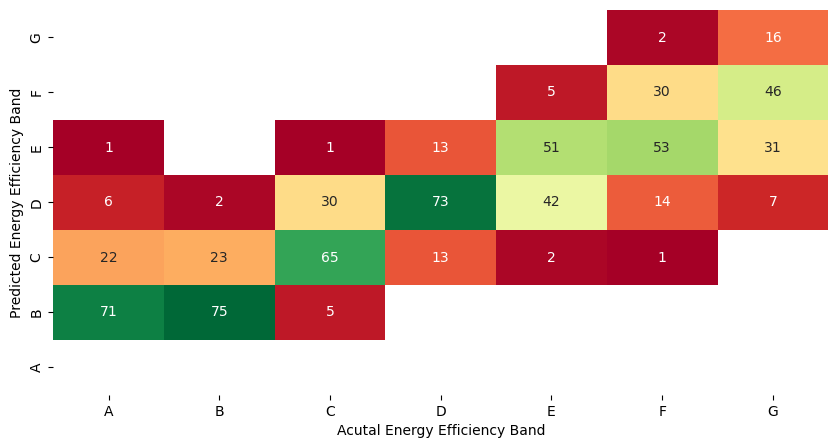

In [34]:
heatmap_test = round(for_heatmap_summed,0)
heatmap_test = heatmap_test.replace(0,np.nan)
heatmap_test = heatmap_test.loc[['G','F','E','D','C','B','A'],:]

f = plt.figure(figsize=(10,5))
sns.heatmap(heatmap_test, cmap='RdYlGn',annot=True,cbar=False)
plt.xlabel('Acutal Energy Efficiency Band')
plt.ylabel('Predicted Energy Efficiency Band')
plt.show()